------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.10.6


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [232]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import pickle, json
from collections import Counter, defaultdict
import requests
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [6]:
# download sentiment lexicon
if not os.path.exists('sent_lexicon'):
    !wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
if not os.path.exists('reviews.json'):
    !wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
    pass

--2022-11-12 22:38:31--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.2’

sent_lexicon.2      100%[===================>] 647.05K  --.-KB/s    in 0.07s   

2022-11-12 22:38:31 (9.33 MB/s) - ‘sent_lexicon.2’ saved [662577/662577]



**Load the movie reviews.**

Each token in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [473]:
def parse_sent_lexicon(line):
    """
    Parse a line from the sentiment lexicon to dict.
    Input:
        line: line from the sentiment lexicon
    Output:
        word, pos: word and part-of-speech tag
        lexicon: dict with type, pos, stemming, polarity and length
    """
    line = line.strip().split()
    pos_dict = {'adj':'JJ', 'noun':'NN', 'verb':'VB', 'anypos':'ANY', 'adverb':'RB'}
    
    word = line[2][6:]
    type = line[0][5:]
    length = line[1][4:]
    pos = line[3][5:] 
    pos = pos_dict[pos] # convert pos tags to nltk pos tags
    stemmed = line[4][9:]
    polarity = line[5][14:]
    
    lexicon = {'type': type, 'length': length, 'pos': pos, 'stemmed': stemmed,  'polarity': polarity}

    return word, lexicon

# create sentiment lexicon
sent_lexicon = {}
with open('sent_lexicon', mode='r', encoding='utf-8') as f:
    for line in f:
        word, lexicon = parse_sent_lexicon(line)
        sent_lexicon[word] = lexicon

In [479]:
def sentiment_classifier(doc, sent_lexicon, magnitude_multiplier=1., threshold=8.0, bias_per_word=0.):
    '''
        Classify a document as positive or negative based on the sentiment lexicon, using a simple binary classifier.
        Inputs: 
            doc - a list of sentences, where a sentence is a list of (token, pos_tag) pairs
            sent_lexicon - a dictionary mapping tokens to sentiment scores
            magnitude_multiplier - a multiplier for the magnitude of the sentiment score
            threshold - the threshold for the sentiment score (float for absolute threshold, 'relative' for relative threshold)
            bias_per_word - avg bias per word in the dataset
        Output:
            sentiment - negative or positive
    '''
    # get sentiment scores for each word
    polarity_score = {'positive': 1, 'negative': -1, 'neutral': 0, 'both': 0}
    polarity_weight = {'strongsubj': magnitude_multiplier, 'weaksubj': 1.}
    sentiment_score = 0
    for sentence in doc:
        for word, pos_tag in sentence:
            word = word.lower() # convert to lowercase
            if word in sent_lexicon.keys():
                if sent_lexicon[word]['pos'] == pos_tag or sent_lexicon[word]['pos'] == 'ANY':
                    sentiment_score += polarity_score[sent_lexicon[word]['polarity']] * polarity_weight[sent_lexicon[word]['type']]
    if threshold=='relative':
        threshold = len(doc)*bias_per_word
    sentiment = 'POS' if sentiment_score > threshold else 'NEG'
    
    return sentiment

In [477]:
with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
sent_labels = [r['sentiment'] for r in reviews]
    
def pred_sentiment(reviews, sent_lexicon, magnitude_multiplier=1., threshold=8.0, bias_per_word=0.):
    '''
        Predict the sentiment of a list of reviews using the sentiment lexicon.
        Inputs:
            reviews - a list of reviews, where a review is a list of sentences, where a sentence is a list of (token, pos_tag) pairs
            sent_lexicon - a dictionary mapping tokens to sentiment scores
            magnitude_multiplier - a multiplier for the magnitude of the sentiment score
            threshold - the threshold for the sentiment score (float for absolute threshold, 'relative' for relative threshold)
            bias_per_word - avg bias per word in the dataset
        Output:
            pred_sent - a list of predicted sentiment labels
    '''
    sent_preds = []
    for review in reviews:
        sent_preds.append(sentiment_classifier(review['content'], sent_lexicon, magnitude_multiplier, threshold, bias_per_word))
    return sent_preds

In [533]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
sent_preds = pred_sentiment(reviews, sent_lexicon, magnitude_multiplier=1., threshold=8.0)
token_results = (np.array(sent_preds) == np.array(sent_labels)).astype(int)
token_accuracy = np.mean(token_results)
print(f'Accuracy of sentiment classifer (without magnitude): {token_accuracy:.3f}')

Accuracy of sentiment classifer (without magnitude): 0.671


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [534]:
# Sentiment classifier with magnitude
sent_preds_magnitude = pred_sentiment(reviews, sent_lexicon, magnitude_multiplier=2., threshold=8.0)
magnitude_results = (np.array(sent_preds_magnitude) == np.array(sent_labels)).astype(int)
magnitude_accuracy = np.mean(magnitude_results)
print(f'Accuracy of sentiment classifer (with magnitude): {magnitude_accuracy:.3f}')

Accuracy of sentiment classifer (with magnitude): 0.693


#### (Q.1.3) Make a barplot of the two results (0.5pt)

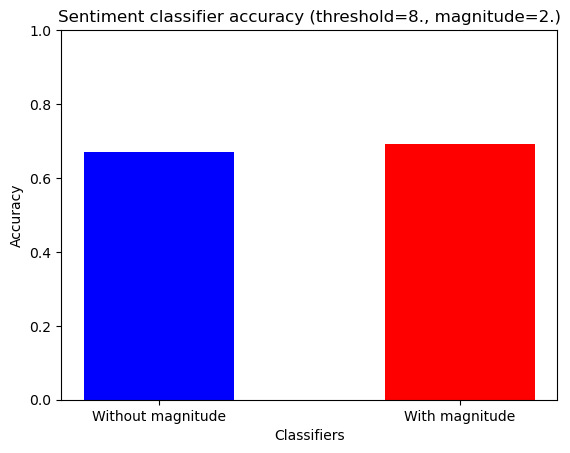

In [535]:
plt.figure()
plt.bar(['Without magnitude', 'With magnitude'], [token_accuracy, magnitude_accuracy], 
        width=0.5, color=['b', 'r'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Sentiment classifier accuracy (threshold=8., magnitude=2.)')
plt.ylim(ymax = 1, ymin = 0)
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The threshold defined is *absolute* but we need to account for document length. As positive words occur at a higher frequency than negative words, longer documents will have greater abolute positive bias than shorter ones. One solution is to adjust the threshold according to the document size.

In [536]:
# Get avg bias for entire dataset
def get_bias_per_word(corpus):
    '''
    Get the average bias per word in the dataset.
    '''
    score = 0
    n_words = 0
    polarity_score = {'positive': 1, 'negative': -1, 'neutral': 0, 'both': 0}
    for doc in corpus:
        for sentence in doc['content']:
            for word, pos_tag in sentence:
                word = word.lower() # convert to lowercase
                if word in sent_lexicon.keys():
                    score += polarity_score[sent_lexicon[word]['polarity']]
            n_words += 1
    bias_per_word = score/n_words
    
    return bias_per_word

bias_per_word = get_bias_per_word(reviews)
print(f'Avg bias per word in dataset = {bias_per_word:1.4f}')

# Classify reviews using relative threshold and magnitude
sent_preds_magnitude_rel = pred_sentiment(reviews, sent_lexicon, magnitude_multiplier=2., threshold='relative', bias_per_word=bias_per_word)
magnitude_rel_results = (np.array(sent_preds_magnitude_rel) == np.array(sent_labels)).astype(int)
magnitude_rel_accuracy = np.mean(magnitude_rel_results)
print(f'Accuracy of sentiment classifer (with magnitude and relative threshold): {magnitude_rel_accuracy:.3f}')

Avg bias per word in dataset = 0.2278
Accuracy of sentiment classifer (with magnitude and relative threshold): 0.694


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

The marginal contribution of word $w$ to log-cond_prob is $\log P(w|C) \in (-\infty, 0)$ (as $P(w|C) \in (0, 1)$). If you skip the word for the class in which it *does not occur*, you add 0 to the log-likehood for that class, and some negative value for the other class, which actually *decreases* the cond_prob for the class in which *does occur*, which is obviously nonsensical. And instead, if we include it only for the class in which it *does not occur*, then the likehood for that class (or joint probability) becomes 0, as it is a product of the individual probabilities and the probability for that class is 0. But this is also too extreme. 

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [537]:
# Create training and test sets
reviews_train = [r for r in reviews if r['cv'] < 900]
reviews_test = [r for r in reviews if r['cv'] >= 900 and r['cv'] < 1000]

In [538]:
def get_unseen_words(reviews):
    '''
    Get a list of words in the training set which only occur in one class.
    Inputs:
        reviews - a list of reviews in the training set
    Output:
        unseen_words - a list of words which only occur in one class
    '''
    pos_words = set()
    neg_words = set()
    for review in reviews:
        for sentence in review['content']:
            for word, pos_tag in sentence:
                word = word.lower() # convert to lowercase
                # if word in sent_lexicon.keys():
                if review['sentiment'] == 'POS':
                    pos_words.add(word)
                else:
                    neg_words.add(word)
    unseen_words = pos_words ^ neg_words
    
    return unseen_words

unseen_words = get_unseen_words(reviews_train)

In [539]:
stem_dict = {}  # global dict of already stemmed words
def extract_features(content, smoothing=0., unseen_words=unseen_words, stem=False, n_grams=[1]):
    '''
    Extract features as ngrams from corpus.
    Inputs:
        content - a list of sentences, where a sentence is a list of (token, pos_tag) pairs
        smoothing - smoothing parameter for unseen words
        unseen_words - a set of words which only occur in one class
        stem - whether to stem the tokens
        n_grams - a list of n for n-grams
    Output:
        features - an iterator of ngrams
    '''
    stemmer = PorterStemmer() if stem else None
    features = []
    for sentence in content:
        # preprocess the sentence
        sentence_preprocessed = []
        for word, pos_tag in sentence:
            word = word.lower() # convert to lowercase
            # remove unseen words if smoothing is not used
            if not smoothing and word in unseen_words:
                continue
            if stem:
                if word in stem_dict:
                    word = stem_dict[word]
                else:
                    word = stemmer.stem(word)
                    stem_dict[word] = word
            sentence_preprocessed.append(word)
        # add all n_grams (from n_grams) to the features
        for n in n_grams:
            features += ngrams(sentence_preprocessed, n, pad_left=True, pad_right=True)

    return Counter(features)


def train_NB(reviews_train, unseen_words=unseen_words, smoothing=0., stem=False, n_grams=[1]):
    '''
    Train a Naive Bayes classifier.
    Inputs:
        reviews_train - a list of reviews in the training set
        smoothing - smoothing parameter for unseen words
        stem - whether to stem the tokens
        n_grams - a list of n for n-grams
    Output:
        prior - a dictionary mapping class labels to prior probabilities
        cond_prob - a dictionary mapping class labels to dictionaries mapping features to conditional probabilities
    '''
    priors = defaultdict(lambda: 0)
    cond_probs = defaultdict(lambda: Counter())

    for r in reviews_train:
        priors[r['sentiment']] += 1
        features = extract_features(r["content"], unseen_words=unseen_words, smoothing=smoothing, stem=stem, n_grams=n_grams)
        cond_probs[r['sentiment']] += features

    # normalize priors
    N_doc = sum(priors.values())
    for sentiment in priors:
        priors[sentiment] /= N_doc

    # normalize cond_probs
    vocabulary = list(sum(cond_probs.values(), Counter()).keys())
    for sentiment in cond_probs:
        normalization = sum(cond_probs[sentiment].values()) + len(vocabulary) * smoothing
        for feature in vocabulary:
            cond_probs[sentiment][feature] = (cond_probs[sentiment][feature] + smoothing) / normalization
        
    
    return priors, cond_probs


def NB_classifier(reviews_test, priors, cond_probs, smoothing=0., stem=False, n_grams=[1]):
    '''
    Classify reviews using a Naive Bayes classifier.
    Inputs:
        reviews_test - a list of reviews in the test set
        priors - a dictionary mapping class labels to prior probabilities
        cond_probs - a dictionary mapping class labels to dictionaries mapping features to conditional probabilities
        stem - whether to stem the tokens
        n_grams - a list of n for n-grams
    Output:
        predictions - a list of predicted class labels
    '''
    predictions = []
    for r in reviews_test:
        features = extract_features(r["content"], smoothing=smoothing, stem=stem, n_grams=n_grams)
        scores = {sentiment: math.log(priors[sentiment]) for sentiment in priors}
        for feature in features:
            if cond_probs['NEG'][feature] != 0 and cond_probs['POS'][feature] != 0:
                for sentiment in scores:
                    scores[sentiment] += math.log(cond_probs[sentiment][feature]) * features[feature]
        
        predictions.append(max(scores, key=scores.get))
    
    return predictions 

In [540]:
# Evaluate NB on the test set
priors, cond_probs = train_NB(reviews_train)
predictions_NB = NB_classifier(reviews_test, priors, cond_probs)
labels_test = [r['sentiment'] for r in reviews_test]
NB_accuracy = (np.array(labels_test) == np.array(predictions_NB)).mean()
print(f'Accuracy of NB classifier: {NB_accuracy:1.3f}')

Accuracy of NB classifier: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Class imbalance in the training set is generally undesirable, as the model can be biased toward the dominant class. In an extreme case, the model could only predict the dominant class for all cases. If class imbalance is also present in the test set, accuracy is not a good metric. For example, if the test set has 90\% occurence of the positive class, a naive model which always predicts the positive class gets a 90\% accuracy. But this is not a good metric as the model had not learnt anything and has 0 accuracy/precision/recall on the negative class. In our case, since the training set contains mostly positive reviews, the algorithm learns to predict the postitive class almost all the time. So it achieves a high accuracy (90\%) on the test set, as it has mostly positive reviews as well. But in fact it performs very poorly on the negative class and would not generalize well to other data.

In [541]:
# Train and test on imbalanced sets
# create imbalanced train set
reviews_train_imbalanced = [r for r in reviews_train if r['sentiment'] == 'POS'] + [r for r in reviews_train if r['sentiment'] == 'NEG' and r['cv'] < 90]
print('The fraction of negative reviews in the imbalanced train set is %1.2f' % (sum([r['sentiment'] == 'NEG' for r in reviews_train_imbalanced])/len(reviews_train_imbalanced)))
# create imbalanced test set
reviews_test_imbalanced = [r for r in reviews_test if r['sentiment'] == 'POS'] + [r for r in reviews_test if r['sentiment'] == 'NEG' and r['cv'] > 900 and r['cv'] < 910]
labels_test_imbalanced = [r['sentiment'] for r in reviews_test_imbalanced]
print('The fraction of negative reviews in the test set using NB is: %.2f' % (labels_test_imbalanced.count('NEG')/len(labels_test_imbalanced)))
# Evaluate on imbalanced test set
# get unseen words
unseen_words_imbalanced = get_unseen_words(reviews_train_imbalanced)
priors, cond_probs = train_NB(reviews_train_imbalanced, unseen_words=unseen_words_imbalanced)
predictions_NB_imbalanced = NB_classifier(reviews_test_imbalanced, priors, cond_probs)
NB_accuracy_imbalanced = (np.array(labels_test_imbalanced) == np.array(predictions_NB_imbalanced)).mean()
print('The fraction of negative reviews in the predictions using NB is %.2f: ' % (predictions_NB_imbalanced.count('NEG')/len(predictions_NB_imbalanced)))
print("Accuracy of NB classifier on imbalanced train/test sets: %1.2f" % NB_accuracy_imbalanced)

The fraction of negative reviews in the imbalanced train set is 0.09
The fraction of negative reviews in the test set using NB is: 0.08
The fraction of negative reviews in the predictions using NB is 0.02: 
Accuracy of NB classifier on imbalanced train/test sets: 0.90


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ 
for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [542]:
# NB classifier with smoothing
priors, cond_probs = train_NB(reviews_train, smoothing=1.)  # laplace smoothing with k=1
predictions_NB_smooth = NB_classifier(reviews_test, priors, cond_probs, smoothing=1.)
nb_acc_smooth = (np.array(labels_test) == np.array(predictions_NB_smooth)).mean()
print(f'Accuracy of NB classifier with smoothing: {nb_acc_smooth:1.3f}')

Accuracy of NB classifier with smoothing: 0.825


Performance remains roughly the same after applying smoothing (test accuracy of ~82%). In the earlier case we were discarding unseen words, now we consider all words with smoothing. It does not appear to make much difference which tenchique we use in this case.

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [516]:
# Implement K-fold cross-validation for the NB classifier with rounding-robin splitting
def kfold_cv_nb(reviews, smoothing=0., stem=False, n_grams=[1], n_folds=10):
    '''
    Perform K-fold cross-validation for the NB classifier.
    Inputs:
        reviews - a list of reviews in the train set
        smoothing - the smoothing parameter
        stem - whether to stem the tokens
        n_grams - a list of n for n-grams
        n_folds - the number of CV folds
    Output:
        mean_accuracy - the average accuracy of the classifier over the folds
        var_accuracy - the variance of the accuracy of the classifier over the folds
    '''
    accuracies = []
    for k in tqdm(range(n_folds)):
        # split the data into train and validation sets using round-robin splitting
        reviews_val = reviews[k::n_folds]
        reviews_train = [r for r in reviews if r not in reviews_val]
        # train the model
        priors, cond_probs = train_NB(reviews_train, smoothing=smoothing, stem=stem, n_grams=n_grams)
        predictions_NB = NB_classifier(reviews_val, priors, cond_probs, smoothing=smoothing, stem=stem, n_grams=n_grams)
        labels_val = [r['sentiment'] for r in reviews_val]
        accuracies.append((np.array(labels_val) == np.array(predictions_NB)).mean())
    mean_accuracy = sum(accuracies) / len(accuracies)
    var_accuracy = sum([(a - mean_accuracy)**2 for a in accuracies]) / len(accuracies)
    
    return mean_accuracy, var_accuracy

In [517]:
nb_acc_mean_cv, nb_acc_var_cv = kfold_cv_nb(reviews_train, smoothing=1., stem=False, n_folds=10)
print(f'Average accuracy of NB classifier with 10-fold CV: {nb_acc_mean_cv:1.3f}')

100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

Average accuracy of NB classifier with 10-fold CV: 0.818


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [518]:
print(f'Variance of accuracy of NB classifier with 10-fold CV: {nb_acc_var_cv:1.5f}')

Variance of accuracy of NB classifier with 10-fold CV: 0.00063


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [105]:
# See train_NB, classifier_NB and extract_features above

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [519]:
nb_acc_stem_mean_cv, nb_acc_stem_var_cv = kfold_cv_nb(reviews_train, smoothing=1., stem=True, n_folds=10)
print(f'Average accuracy of NB classifier (with stemming) using 10-fold CV: {nb_acc_stem_mean_cv:1.3f}')
print(f'Variance of accuracy of NB classifier (with stemming) using 10-fold CV: {nb_acc_stem_var_cv:1.5f}')

100%|██████████| 10/10 [01:06<00:00,  6.66s/it]

Average accuracy of NB classifier (with stemming) using 10-fold CV: 0.812
Variance of accuracy of NB classifier (with stemming) using 10-fold CV: 0.00095


The performance is roughly the same when applying stemming (~82% CV accuracy over 10 folds). The algorithm takes slighty longer when running for the first time, as it has to stem all the words in the vocabulary. But the tradeoff is that we can use a smaller vocabulary, thus achieving compression/dimensionality reduction without much information loss.

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [521]:
vocab_unstemmed, vocab_stemmed = Counter(), Counter()
for r in reviews_train:
    vocab_unstemmed += extract_features(r["content"], smoothing=1., stem=False)
    vocab_stemmed += extract_features(r["content"], smoothing=1., stem=True)
print(f'The size of the vocabulary without stemming: {len(vocab_unstemmed)}')
print(f'The size of the vocabulary with stemming: {len(vocab_stemmed)}')

The size of the vocabulary without stemming: 45348
The size of the vocabulary with stemming: 32332


The size of the vocabulary drops significantly when applying stemming, as various inflections of the root collapse to the same stem.

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [522]:
# Compare different ngram models with K-fold CV
print(f'Average accuracy of NB classifier (with stemming) over 10 folds with unigrams: {nb_acc_smooth:1.3f}')
# print(f'Variance of accuracy of NB classifier (with stemming) over 10 folds, using unigrams: {np.var(nb_acc_smooth):1.5f}')
# NB classifier with unigrams+bigrams
nb_stem_ub_acc_cv, _ = kfold_cv_nb(reviews, smoothing=0., stem=True, n_grams=[1, 2], n_folds=10)
print(f'Average accuracy of NB classifier (with stemming) over 10 folds, using unigrams+bigrams: {nb_stem_ub_acc_cv:1.3f}')
# NB classifier with unigrams+bigrams+trigrams
nb_stem_ubt_acc_cv, _ = kfold_cv_nb(reviews, smoothing=0., stem=True, n_grams=[1, 2, 3], n_folds=10)
print(f'Average accuracy of NB classifier (with stemming) over 10 folds, using unigrams+bigrams+trigrams: {nb_stem_ubt_acc_cv:1.3f}')

Average accuracy of NB classifier (with stemming) over 10 folds with unigrams: 0.825


100%|██████████| 10/10 [02:55<00:00, 17.53s/it]


Average accuracy of NB classifier (with stemming) over 10 folds, using unigrams+bigrams: 0.827


100%|██████████| 10/10 [06:45<00:00, 40.59s/it]

Average accuracy of NB classifier (with stemming) over 10 folds, using unigrams+bigrams+trigrams: 0.835


Generally, using more ngrams results in a richer model with more contextual understanding (as we can capture semantic relationships between phrases of words), which allows us to better understand the document's context. The prolem is that this is computationally expensive, as the complxeity grows as $O(n^k)$ where n is the vocabulary length and $k$ is the largest ngram. Moreover, we also need the much larger and richer dataset, as otherwise we would end up with very sparse models (as most of these higher ngrams occur rarely). 

This seems to be the case here. The accuracy remains roughly the same as before (around 83\%), when using unigrams+trigrams, and unigrams+bigrams+trigrams. But the computational complexity (both time and space) grows exponentially with the number of ngrams. This could be because the dataset is too small for using bigrams and trigrams, and as such they don't contribute much useful informaion. We would be better off simply using unigrams without any loss of performance (and vastly improving computational efficiency).


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


In [523]:
vocab_u, vocab_ub, vocab_ubt = Counter(), Counter(), Counter()
for r in reviews_train:
    vocab_u += extract_features(r['content'], smoothing=1., stem=True, n_grams=[1])
    vocab_ub += extract_features(r['content'], smoothing=1., stem=True, n_grams=[1, 2])
    vocab_ubt += extract_features(r['content'], smoothing=1., stem=True, n_grams=[1, 2, 3])
print(f'The number of features in the vocabulary with unigrams: {len(vocab_u)}')
print(f'The number of features in the vocabulary with unigrams+bigrams: {len(vocab_ub)}')
print(f'The number of features in the vocabulary with unigrams+bigrams+trigrams: {len(vocab_ubt)}')

The number of features in the vocabulary with unigrams: 32334
The number of features in the vocabulary with unigrams+bigrams: 412827
The number of features in the vocabulary with unigrams+bigrams+trigrams: 1306759


For a document with $n$ words, the number of unigrams equals $n$. In the worst case, the number of bigrams is $n^2$, if every word pairs with every other word in the vocabulary including itself. For trigrams, this becomes $n^3$. Although the worst case is highly unlikely because of grammar, in theory this number grows in order of polynomial time. For our case we observe that on increasing the number of ngrams, the vocabulary size increases by an order of magnitude each time.

# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [441]:
def extract_features_svm(corpus, use_pos=False, stem=False, allow_closed_classes=True):
    '''
    Extract features from corpus using token counts.
    Input:
        corpus: training corpus
        use_pos: a boolean indicating whether to use part-of-speech tags
        stem: a boolean indicating whether to use stemming
        allow_closed_classes: a boolean indicating whether to allow closed classes
    Output:
        features: a list of preprocessed strings corresponding to each text in the corpus
    '''
    stemmer = PorterStemmer() if stem else None
    features = []
    for doc in corpus:
        text = ''
        for sentence in doc['content']:
            for word, pos_tag in sentence:
                if not allow_closed_classes and not pos_tag.startswith(('NN', 'JJ', 'VB', 'RB')):
                    continue
                word = word.lower()
                if stem:
                    if word in stem_dict:
                        word = stem_dict[word]
                    else:
                        word = stemmer.stem(word)
                        stem_dict[word] = word
                        word = stemmer.stem(word)
                if use_pos:
                    text += f'{word}_{pos_tag} '
                else:
                    text += f'{word} '
        features.append(text)

    return features

In [527]:
def kfold_cv_svc(reviews, use_pos=False, stem=False, allow_closed_classes=True, n_folds=10):
    '''
    Implement K-fold cross-validation for the SVC with rounding-robin splitting.
    Input:
        reviews: a list of reviews
        use_pos: a boolean indicating whether to use part-of-speech tags
        stem: a boolean indicating whether to use stemming
        allow_closed_classes: a boolean indicating whether to allow closed classes
        n_folds: the number of folds
    Output:
        accuracies: a list of accuracies for each fold
    '''
    accuracies = []
    count_vectorizer = CountVectorizer(lowercase=False)
    for k in tqdm(range(n_folds)):
        reviews_val = reviews[k::n_folds]
        reviews_train = [r for r in reviews if r not in reviews_val]
        X_train = extract_features_svm(reviews_train, use_pos, stem, allow_closed_classes)
        X_train = count_vectorizer.fit_transform(X_train)
        y_train = [r['sentiment'] for r in reviews_train]
        X_val = extract_features_svm(reviews_val, use_pos, stem, allow_closed_classes)
        X_val = count_vectorizer.transform(X_val)
        y_val = [r['sentiment'] for r in reviews_val]
        svc = LinearSVC(max_iter=10000)
        svc.fit(X_train, y_train)
        accuracies.append(svc.score(X_val, y_val))
    mean_accuracy = sum(accuracies) / len(accuracies)
    var_accuracy = sum([(a - mean_accuracy)**2 for a in accuracies]) / len(accuracies)
    
    return mean_accuracy, var_accuracy

In [530]:
# Evaluate the SVC classifier with K-fold CV
warnings.filterwarnings('ignore')   # ignore convergence warnings
svc_acc_cv_mean, svc_acc_cv_var = kfold_cv_svc(reviews_train, n_folds=10, use_pos=False, stem=False, allow_closed_classes=True)
print(f'Average accuracy of SVC (no POS and all classes) with 10-fold CV: {svc_acc_cv_mean:1.3f}')
print(f'Variance of accuracy of SVC (noi POS and all classes) with 10-fold CV: {svc_acc_cv_var:1.5f}')

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]

Average accuracy of SVC (no POS and all classes) with 10-fold CV: 0.834
Variance of accuracy of SVC (noi POS and all classes) with 10-fold CV: 0.00075


The SVM classifier exhibits similar performance to the Naive Bayes classifier with smoothing (accuracy ~83% over 10-folds on training set). 

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [543]:
# Evaluate the SVC classifier with POS with K-fold CV
svc_pos_acc_cv_mean, svc_pos_acc_cv_var = kfold_cv_svc(reviews_train, n_folds=10, use_pos=True, stem=False, allow_closed_classes=True)
print(f'Average accuracy of SVC (with POS) with 10-fold CV: {svc_pos_acc_cv_mean:1.3f}')
print(f'Variance of accuracy of SVC (with POS) with 10-fold CV: {svc_pos_acc_cv_var:1.5f}')

100%|██████████| 10/10 [00:26<00:00,  2.66s/it]

Average accuracy of SVC (with POS) with 10-fold CV: 0.840
Variance of accuracy of SVC (with POS) with 10-fold CV: 0.00046


The accuracy remians roughly the same (around 84%) when using POS tags in the features. So POS disambiguation does not help much. It could be that the words convey the same sentiment (or no sentiment) even when used in different parts-of-speech. Or it could be simply because POS disambiguation is not very common in the dataset so it does not have a large impact on performance.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [493]:
# Evaluate the SVC classifier with POS and no closed classes with K-fold CV
svc_pos_nocc_acc_cv_mean, svc_pos_nocc_acc_cv_var = kfold_cv_svc(reviews_train, n_folds=10, use_pos=True, stem=False, allow_closed_classes=False)
print(f'Average accuracy of SVC (with POS and no closed classes) using 10-fold CV: {svc_pos_nocc_acc_cv_mean:1.3f}')
print(f'Variance of accuracy of SVC (with POS and no closed classes) using 10-fold CV: {svc_pos_nocc_acc_cv_var:1.5f}')

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

Average accuracy of SVC (with POS) with 10-fold CV: 0.843
Variance of accuracy of SVC (with POS) with 10-fold CV: 0.00056


The performance does not change much from ealier (accuracy ~84\%). Intuitively, using only open-class words makes more sense as these convey the most information about the sentiment, while closed-class words do not convey much. So we do not lose much information by discarding the closed-class works, as our results indicate. But we also don't get a large performance boost, perhaps because the SVM algorithm was already assigning small weights to those features. But it would still make sense to discard them since we can compress the feature space without losing information.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


#### Lexicon-based approach
We use a lexicon containing the polarity (and magnitude) of words in the vocabulary. Then we compute the overall sentiment of an article as the (magnitude-weighted) sum of their constituent words, while accounting for positive bias (using either a absolute or relative threshold). The performance is decent (~67–70% accuracy on our entire dataset), it is limited by the fact that the lexicon is *fixed* (as it does not learn from the data) and *per-word*. It cannot adapt to the specific context in the corpus, and also cannot learn relationships between individual words and between the words and the article context. Using magnitude information and relative thresholding improve the performance somewhat, but the method is inherently too simplistic to be effective.

#### Naive Bayes
Unlike the lexicon-based approach, Naive Bayes actually *learns* the priors and conditional probabilities from the text. We see a drastic improvement on our dataset with NB, getting an accuracy of ~83% on the test set and ~82% using 10-fold cross-validation on the training set, using only unigrams. One challenge in NB is dealing with *unseen words* which occur in only one class, or only in the test set, which could lead to absurd results as the conditional probabilities are zero (and the log-likelihood undefined). One solution is to discard all such words, while another is *Laplacian smoothing*. Both approaches yield similar results in our test dataset (~83%, similar to the baseline). We can also use *stemming* to retain only the root forms of the word; this allows feature compression without much information loss (in our dataset we reduce the vocabulary size from ~45000 to ~ 32000 while the 10-fold CV accuracy stays at around 82%). Finally, we can include more ngrams in the model to capture phrases and contexts better, leading to a richer model. However, this greatly increases computational complexity (order of polynomial time) and also requires a much larger dataset (else we would get very sparse models as higher ngrams occur rarely). We see this problem in our dataset, as including bigrams and trigrams increases the vocabulary by an order of magnitude each time, but the performance stays the same (~82% CV acc. over 10 folds), probably because our dataset is too small for these ngrams.

#### SVM
SVM differs from Naive Bayes in that it is non-probabilistic and simply tries to maximize separation between points in different classes. Here the features are the token counts in the corpus. Its performance on the training dataset is similar to NB (~83% CV accuracy over 10 folds). This doesn't change on incorporating part-of-speech tags in the features, perhaps because different POS forms convey the same sentiment, or there is not much POS disambiguation in the data. We could also discard closed-class words as they do not convey sentiment, thus acheiving dimensionality reduction without much information loss. In our dataset the performance remain roughly the same, around 84% CV accuracy (10 folds). 

# Submission 


Abhinav Bhuyan, 12434817

Job Gräber 12440272

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 